In [1]:
# Import the necessary libraries
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
from random import gauss
from random import seed
import scipy 
import pandas as pd

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller, kpss

import arch
from arch.univariate import ARX, GARCH, Normal
from arch.unitroot import DFGLS
from arch.univariate import arch_model
from arch import arch_model

import datetime as dt
import pandas_datareader.data as web

from scipy.stats import pearsonr

In [2]:
### Data 2010-2015 ###

In [3]:
# FTSE100 2010-2015

FTSE100 = pd.read_csv('Data/FTSE100 2015.csv',index_col = 'Date', decimal = ".", delimiter = ',', thousands = ",")

# Set the date as index
FTSE100.index = pd.to_datetime(FTSE100.index)

# Rename Column 'Close Price' to 'FTSE100'
FTSE100.rename(columns={'Close Price':'FTSE100'}, inplace=True)

# Drop redundant columns
FTSE100.drop(['Open Price', 'High Price','Low Price', 'Volume'], axis = 1, inplace=True)

In [4]:
# Gold Future 2010-2015

GoldFuture = pd.read_excel('Data/Gold Future 2015.xlsx')

# Set the exchange date as index
GoldFuture.set_index('Exchange Date', inplace = True)

# Rename Column 'Close' to 'GoldFuture'
GoldFuture.rename(columns={'Close':'GoldFuture'}, inplace=True)

# Drop redundant columns
GoldFuture.drop(['Volume', 'Net', '%Chg', 'Open','Low', 'High', 'Mid', 'OI', 'O-C', 'H-L', '%CVol', '%COI'], axis = 1, inplace=True)

In [5]:
# Gold Spot 2010-2015

GoldSpot = pd.read_csv('Data/GoldSpot_2015.csv', index_col = "Date", decimal = ".", delimiter = ',', thousands = ",")

# Set the date as index
GoldSpot.index = pd.to_datetime(GoldSpot.index)

# Rename Column 'Price' to 'GoldSpot'
GoldSpot.rename(columns={'Price':'GoldSpot'}, inplace=True)

# Drop redundant columns
GoldSpot.drop(['Open_GoldSpot', 'High','Low', 'Change %'], axis = 1, inplace=True)

In [6]:
# Fed Fund Rate 2010-2015

FedFund = pd.read_excel('Data/FedFundRate 2015.xlsx')

# Set the exchange date as index
FedFund.set_index('Date', inplace = True)
FedFund.index = pd.to_datetime(FedFund.index)

# Rename Column 'Rate_FedFund' to 'FedFund'
FedFund.rename(columns={'Rate_FedFund':'FedFund'}, inplace=True)

In [7]:
# USDGBP 2010-2015

USDGBP = pd.read_excel('Data/USDGBP 2015.xlsx')

# Set the exchange date as index
USDGBP.set_index('Exchange Date', inplace = True)

# Rename Column 'Mid' to 'USDGBP'
USDGBP.rename(columns={'Mid':'USDGBP'}, inplace=True)

# Drop redundant columns
USDGBP.drop(['Bid', 'Ask', 'High', 'Low', 'Open', 'RefreshRate', 'BidNet', 'Bid%Chg'], axis = 1, inplace=True)

In [8]:
# USDEUR 2010-2015

USDEUR = pd.read_excel('Data/USDEUR 2015.xlsx')

# Set the exchange date as index
USDEUR.set_index('Exchange Date', inplace = True)

# Rename Column 'Mid' to 'USDEUR'
USDEUR.rename(columns={'Mid':'USDEUR'}, inplace=True)

# Drop redundant columns
USDEUR.drop(['Bid', 'Ask', 'High', 'Low', 'Open', 'RefreshRate', 'BidNet', 'Bid%Chg'], axis = 1, inplace=True)

In [9]:
# Bitcoin, ln(Bitcoin) and Bitcoin returns 2010-2015

Bitcoin = pd.read_excel('Data/Bitcoin 2015_added.xlsx')

# Set the date as index
Bitcoin.set_index('Date', inplace = True)

# Rename Column 'Closing Price' to 'Bitcoin'
Bitcoin.rename(columns={'Closing Price (USD)':'Bitcoin'}, inplace=True)

# Drop redundant columns
Bitcoin.drop(['24h Open (USD)', '24h High (USD)', '24h Low (USD)'], axis = 1, inplace=True)

# Construct the logged Bitcoin and the returns of Bitcoin
ln_Bitcoin = np.log(Bitcoin)
Bitcoin_r = (np.log(Bitcoin) - np.log(Bitcoin.shift(1)))
Bitcoin_r = Bitcoin_r.dropna()

In [10]:
# Rename ln_Bitcoin's and Bitcoin_r's columns
ln_Bitcoin.rename(columns={'Bitcoin':'Ln(Bitcoin)'}, inplace=True)
Bitcoin_r.rename(columns={'Bitcoin':'Bitcoin return'}, inplace=True)

In [11]:
# Complete Data 2010 - 2015
data = pd.concat([Bitcoin, ln_Bitcoin, Bitcoin_r, FedFund, USDEUR, USDGBP, FTSE100, GoldFuture, GoldSpot], axis = 1)

In [12]:
# Fill missed weekend days with zero returns
while data.isna().sum().sum() != 0:
    data = data.fillna(data.shift(1))

In [13]:
# Sort Data from newest to oldest
Data15 = data.sort_index(ascending=False)

In [14]:
# Summary statistics
Data15_stats = Data15.describe(percentiles=[])
Data15_stats = Data15_stats.transpose()

In [15]:
# AR(1)-Process - Data 2010-2015

ar1 = pd.DataFrame(np.zeros(len(Data15.columns)), columns=['AR(1)'], index=Data15_stats.index)
pval = pd.DataFrame(np.zeros(len(Data15.columns)), columns=['AR(1)'], index=Data15_stats.index)

for i in range(len(Data15.columns)):
    AR_Input = Data15.iloc[:,i].dropna()

    # fit the AR(1) model
    order = (1,0)
    ar_1 = ARMA(AR_Input, order=order)
    ar_1_fit = ar_1.fit()

    ar1.iloc[i] = ar_1_fit.params[1].round(4)
    pval.iloc[i] = ar_1_fit.pvalues[1]

# create three masks
s1 = ar1.applymap(lambda x: '{}*'.format(x))
s2 = ar1.applymap(lambda x: '{}**'.format(x))
s3 = ar1.applymap(lambda x: '{}***'.format(x))
# apply them where appropriate
for j in range(len(ar1)):
    ar1 = ar1.mask(pval<=0.1,s1)
    ar1 = ar1.mask(pval<=0.05,s2)
    ar1 = ar1.mask(pval<=0.01,s3)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/usr/local/lib/python3.6/dist-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/usr/local/lib/python3.6/dist-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[se

In [16]:
# Augmented Dickey-Fuller test - Data 2010-2015

adf = pd.DataFrame(np.zeros(len(Data15.columns)), columns=['ADF'], index=Data15_stats.index)
pval = pd.DataFrame(np.zeros(len(Data15.columns)), columns=['ADF'], index=Data15_stats.index)
for j in range(len(Data15.columns)):
    adf.iloc[j] = adfuller(Data15.iloc[:,j].dropna())[0].round(2)
    pval.iloc[j] = adfuller(Data15.iloc[:,j].dropna())[1]
# create three masks
s1 = adf.applymap(lambda x: '{}*'.format(x))
s2 = adf.applymap(lambda x: '{}**'.format(x))
s3 = adf.applymap(lambda x: '{}***'.format(x))
# apply them where appropriate
for i in range(len(adf)):
    adf = adf.mask(pval<=0.1,s1)
    adf = adf.mask(pval<=0.05,s2)
    adf = adf.mask(pval<=0.01,s3)

In [17]:
# Complete summary statistics 2010-2015
Data15_stats['AR(1)'] = ar1
Data15_stats['ADF'] = adf
Data15_stats

,count,mean,std,min,50%,max,AR(1),ADF
Bitcoin,1769.0,170.493276,239.841365,0.050500,15.843040,1154.925930,0.9968***,-1.35
Ln(Bitcoin),1769.0,3.167355,2.670512,-2.985782,2.762730,7.051791,0.9998***,0.41
Bitcoin return,1769.0,-0.004514,0.077341,-1.004342,0.000109,1.039266,-0.0783***,-8.21***
FedFund,1769.0,0.117744,0.039014,0.040000,0.110000,0.210000,0.9699***,-1.16
USDEUR,1769.0,1.316255,0.079829,1.049500,1.324050,1.482750,0.9977***,-2.76*
USDGBP,1769.0,1.590896,0.050580,1.463150,1.589600,1.716550,0.9925***,-2.49
FTSE100,1769.0,6150.996495,523.073034,4944.440000,6060.090000,7103.980000,0.9972***,-1.75
GoldFuture,1769.0,1441.224364,194.081194,1142.300000,1384.700000,1888.700000,0.9975***,-1.41
GoldSpot,1769.0,1442.228943,194.206248,1141.200000,1384.850000,1900.490000,0.9977***,-1.43


In [18]:
# Correlation Matrix of Data15

# Define function for calculating the related p-values of the correlations
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

# Calculate the correlation matrix and assemble with p-values
rho = Data15.corr()
rho = rho.round(3)
pval = calculate_pvalues(Data15)
# create three masks
r1 = rho.applymap(lambda x: '{}*'.format(x))
r2 = rho.applymap(lambda x: '{}**'.format(x))
r3 = rho.applymap(lambda x: '{}***'.format(x))
# apply them where appropriate
rho = rho.mask(pval<=0.1,r1)
rho = rho.mask(pval<=0.05,r2)
rho = rho.mask(pval<=0.01,r3)
rho

,Bitcoin,Ln(Bitcoin),Bitcoin return,FedFund,USDEUR,USDGBP,FTSE100,GoldFuture,GoldSpot
Bitcoin,1.0***,0.762***,0.051**,-0.473***,-0.013,0.472***,0.702***,-0.596***,-0.597***
Ln(Bitcoin),0.762***,1.0***,0.051**,-0.633***,-0.224***,0.204***,0.82***,-0.385***,-0.385***
Bitcoin return,0.051**,0.051**,1.0***,-0.028,-0.041*,-0.002,-0.005,-0.004,-0.004
FedFund,-0.473***,-0.633***,-0.028,1.0***,-0.208***,-0.29***,-0.382***,0.098***,0.097***
USDEUR,-0.013,-0.224***,-0.041*,-0.208***,1.0***,0.649***,-0.292***,0.278***,0.279***
USDGBP,0.472***,0.204***,-0.002,-0.29***,0.649***,1.0***,0.105***,-0.001,-0.002
FTSE100,0.702***,0.82***,-0.005,-0.382***,-0.292***,0.105***,1.0***,-0.66***,-0.66***
GoldFuture,-0.596***,-0.385***,-0.004,0.098***,0.278***,-0.001,-0.66***,1.0***,1.0***
GoldSpot,-0.597***,-0.385***,-0.004,0.097***,0.279***,-0.002,-0.66***,1.0***,1.0***


In [19]:
### Data 2010-2017 ###

In [20]:
# Bitcoin returns 2010-2017

BTC17 = pd.read_excel('Data/Bitcoin 2017_added.xlsx')

# Set the date as index
BTC17.set_index('Date', inplace = True)

# Rename Column 'Closing Price' to 'Bitcoin'
BTC17.rename(columns={'Closing Price (USD)':'Bitcoin'}, inplace=True)

# Drop redundant columns
BTC17.drop(['24h Open (USD)', '24h High (USD)', '24h Low (USD)'], axis = 1, inplace=True)

# Construct the returns of Bitcoin
BTC17_r = 100 * (np.log(BTC17) - np.log(BTC17.shift(-1)))
BTC17_r = BTC17_r.dropna()

In [21]:
# Fed Fund Rate 2010-2017

FedFund17 = pd.read_excel('Data/FedFundRate 2017.xls')

# Set the exchange date as index
FedFund17.set_index('Date', inplace = True)
FedFund17.index = pd.to_datetime(FedFund17.index)

# Rename Column 'Rate_FedFund' to 'FedFund'
FedFund17.rename(columns={'Rate':'FedFund'}, inplace=True)

# Construct the returns
FedFund17_r = (np.log(FedFund17) - np.log(FedFund17.shift(-1)))
FedFund17_r = FedFund17_r.dropna()

In [22]:
# FTSE100 2010-2017

FTSE17 = pd.read_excel('Data/FTSE100 2017.xlsx')

# Set the exchange date as index
FTSE17.set_index('Exchange Date', inplace = True)

# Rename Column 'Close' to 'FTSE100'
FTSE17.rename(columns={'Close':'FTSE100'}, inplace=True)

# Drop redundant columns
FTSE17.drop(['Volume', 'Net', '%Chg', 'Open','Low', 'High', 'Mid', 'Turnover - GBP', 'Approx VWAP', 'O-C', 'H-L', '%CVol', '%CTurn'], axis = 1, inplace=True)
FTSE17

# Construct the returns
FTSE17_r = 100 * (np.log(FTSE17) - np.log(FTSE17.shift(-1)))
FTSE17_r = FTSE17_r.dropna()

In [23]:
# Gold Future 2010-2017

GoldFuture17 = pd.read_excel('Data/Gold Future 2017.xlsx')

# Set the exchange date as index
GoldFuture17.set_index('Exchange Date', inplace = True)

# Rename Column 'Close' to 'GoldFuture'
GoldFuture17.rename(columns={'Close':'GoldFuture'}, inplace=True)

# Drop redundant columns
GoldFuture17 = GoldFuture17.iloc[:,:1]
GoldFuture17

# Construct the returns
GoldFuture17_r = 100 * (np.log(GoldFuture17) - np.log(GoldFuture17.shift(-1)))
GoldFuture17_r = GoldFuture17_r.dropna()

In [24]:
# Gold Spot 2010-2017

GoldSpot17 = pd.read_csv('Data/GoldSpot_2017.csv', index_col = "Date", decimal = ".", delimiter = ',', thousands = ",")

# Set the date as index
GoldSpot17.index = pd.to_datetime(GoldSpot17.index)

# Rename Column 'Price' to 'GoldSpot'
GoldSpot17.rename(columns={'Price':'GoldSpot'}, inplace=True)

#Drop redundant columns
GoldSpot17.drop(['Open', 'High','Low', 'Change %'], axis = 1, inplace=True)

# Construct the returns
GoldSpot17_r = 100 * (np.log(GoldSpot17) - np.log(GoldSpot17.shift(-1)))
GoldSpot17_r = GoldSpot17_r.dropna()

In [25]:
# MSCI 2010-2017

MSCI17 = pd.read_excel('Data/MSCI 2017.xlsx')

# Set the exchange date as index
MSCI17.set_index('Exchange Date', inplace = True)

# Rename Column 'Close' to 'MSCI'
MSCI17.rename(columns={'Close':'MSCI'}, inplace=True)

# Drop redundant columns
MSCI17.drop(['Volume', 'Net', '%Chg', 'Open','Low', 'High', 'Mid', 'Turnover - USD', 'Approx VWAP', 'O-C', 'H-L', '%CVol', '%CTurn'], axis = 1, inplace=True)
MSCI17

# Construct the returns
MSCI17_r = 100 * (np.log(MSCI17) - np.log(MSCI17.shift(-1)))
MSCI17_r = MSCI17_r.dropna()

In [26]:
# EUR FX Index 2010-2017

EUR17 = pd.read_csv('Data/EURFX 2017.csv', index_col = "Date", decimal = ".", delimiter = ',', thousands = ",")

# Set the date as index
EUR17.index = pd.to_datetime(EUR17.index)

# Rename Column 'Price' to 'EURFX'
EUR17.rename(columns={'Price':'EURFX'}, inplace=True)

#Drop redundant columns
EUR17.drop(['Open', 'High','Low', 'Vol.', 'Change %'], axis = 1, inplace=True)

# Construct the returns
EUR17_r = 100 * (np.log(EUR17) - np.log(EUR17.shift(-1)))
EUR17_r = EUR17_r.dropna()

In [27]:
# USD FX Index 2010-2017

USD17 = pd.read_csv('Data/USDFX 2017.csv', index_col = "Date", decimal = ".", delimiter = ',', thousands = ",")

# Set the date as index
USD17.index = pd.to_datetime(USD17.index)

# Rename Column 'Price' to 'USDFX'
USD17.rename(columns={'Value':'USDFX'}, inplace=True)

# Construct the returns
USD17_r = 100 * (np.log(USD17) - np.log(USD17.shift(-1)))
USD17_r = USD17_r.dropna()

In [28]:
# USDEUR 2010-2017

USDEUR17 = pd.read_excel('Data/USDEUR 2017.xlsx')

# Set the exchange date as index
USDEUR17.set_index('Exchange Date', inplace = True)

# Rename Column 'Mid' to 'USDEUR'
USDEUR17.rename(columns={'Mid':'USDEUR'}, inplace=True)

#Drop redundant columns
USDEUR17.drop(['Bid', 'Ask', 'High', 'Low', 'Open', 'RefreshRate', 'BidNet', 'Bid%Chg'], axis = 1, inplace=True)

# Construct the returns
USDEUR17_r = 100 * (np.log(USDEUR17) - np.log(USDEUR17.shift(-1))) 
USDEUR17_r = USDEUR17_r.dropna()

In [29]:
# USDGBP 2010-2017

USDGBP17 = pd.read_excel('Data/USDGBP 2017.xlsx')

# Set the exchange date as index
USDGBP17.set_index('Exchange Date', inplace = True)

# Rename Column 'Mid' to 'USDGBP'
USDGBP17.rename(columns={'Mid':'USDGBP'}, inplace=True)

#Drop redundant columns
USDGBP17.drop(['Bid', 'Ask', 'High', 'Low', 'Open', 'RefreshRate', 'BidNet', 'Bid%Chg'], axis = 1, inplace=True)

# Construct the returns
USDGBP17_r = 100 * (np.log(USDGBP17) - np.log(USDGBP17.shift(-1))) 
USDGBP17_r = USDGBP17_r.dropna()

In [30]:
# Complete Data 2010-2017

Data17 = pd.concat([BTC17_r, FedFund17_r, USDEUR17_r, USDGBP17_r, USD17_r, EUR17_r, FTSE17_r, MSCI17_r, GoldFuture17_r, GoldSpot17_r], axis = 1)
Data17 = Data17.sort_index(ascending=False)

# Summary statistics
Data17_stats = Data17.describe(percentiles=[])
Data17_stats.loc['skew'] = Data17.skew().tolist()
Data17_stats.loc['kurt'] = Data17.kurtosis().tolist()
Data17_stats = Data17_stats.transpose()

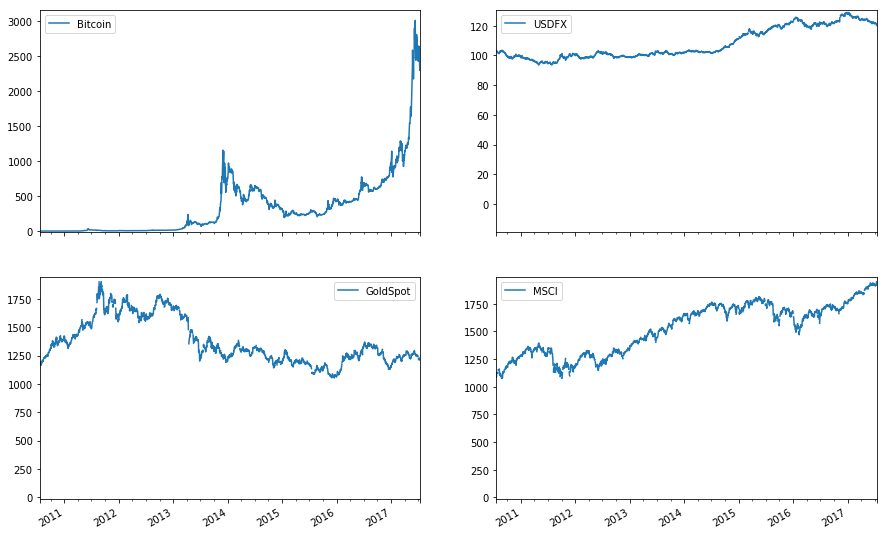

In [31]:
# Plot prices 2010-2017

plt.rcParams['figure.figsize'] = [15, 10] #set figure width, height
Plot17 = pd.concat([BTC17, USD17, GoldSpot17, MSCI17], axis = 1)
Plot17.plot(subplots=True, layout=(2,2), color='tab:blue', ylim=(-19))
plt.show()

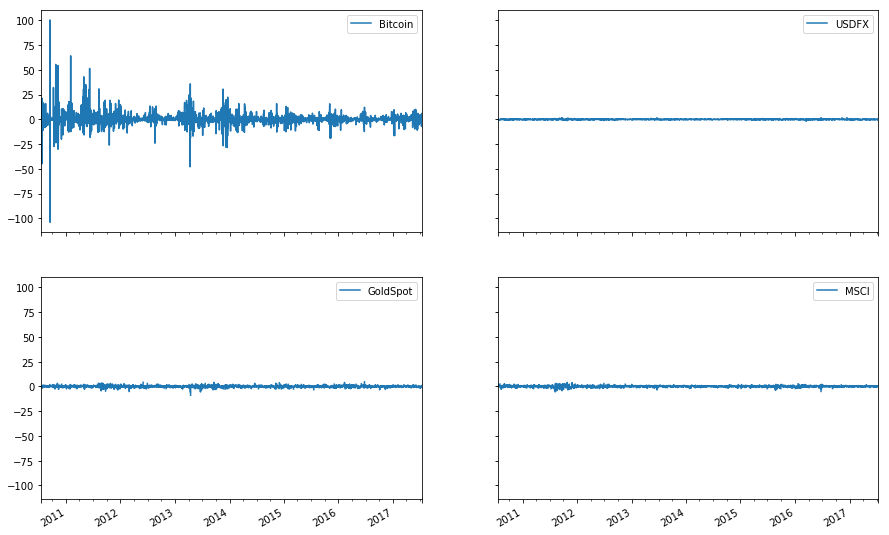

In [32]:
# Plot returns 2010-2017

plt.rcParams['figure.figsize'] = [15, 10] #set figure width, height
Plot17_r = pd.concat([BTC17_r, USD17_r, GoldSpot17_r, MSCI17_r], axis = 1)
Plot17_r.plot(subplots=True, layout=(2,2), color='tab:blue', sharey=True)
plt.show()

In [33]:
# AR(1)-Process - Data 2010-2017

ar1 = pd.DataFrame(np.zeros(len(Data17.columns)), columns=['AR(1)'], index=Data17_stats.index)
pval = pd.DataFrame(np.zeros(len(Data17.columns)), columns=['AR(1)'], index=Data17_stats.index)

for i in range(len(Data17.columns)):
    AR_Input = Data17.iloc[:,i].dropna()

    # fit the AR(1) model
    order = (1,0)
    ar_1 = ARMA(AR_Input, order=order)
    ar_1_fit = ar_1.fit()

    ar1.iloc[i] = ar_1_fit.params[1].round(4)
    pval.iloc[i] = ar_1_fit.pvalues[1]

# create three masks
s1 = ar1.applymap(lambda x: '{}*'.format(x))
s2 = ar1.applymap(lambda x: '{}**'.format(x))
s3 = ar1.applymap(lambda x: '{}***'.format(x))
# apply them where appropriate
for j in range(len(ar1)):
    ar1 = ar1.mask(pval<=0.1,s1)
    ar1 = ar1.mask(pval<=0.05,s2)
    ar1 = ar1.mask(pval<=0.01,s3)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/usr/local/lib/python3.6/dist-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/usr/local/lib/python3.6/dist-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[se

In [34]:
# Augmented Dickey-Fuller test - Data 2010-2017

adf = pd.DataFrame(np.zeros(len(Data17.columns)), columns=['ADF'], index=Data17_stats.index)
pval = pd.DataFrame(np.zeros(len(Data17.columns)), columns=['ADF'], index=Data17_stats.index)
for j in range(len(Data17.columns)):
    adf.iloc[j] = adfuller(Data17.iloc[:,j].dropna())[0].round(2)
    pval.iloc[j] = adfuller(Data17.iloc[:,j].dropna())[1]
# create three masks
s1 = adf.applymap(lambda x: '{}*'.format(x))
s2 = adf.applymap(lambda x: '{}**'.format(x))
s3 = adf.applymap(lambda x: '{}***'.format(x))
# apply them where appropriate
for i in range(len(adf)):
    adf = adf.mask(pval<=0.1,s1)
    adf = adf.mask(pval<=0.05,s2)
    adf = adf.mask(pval<=0.01,s3)

In [35]:
# Complete summary statistics 2010-2017
Data17_stats['AR(1)'] = ar1
Data17_stats['ADF'] = adf
Data17_stats

,count,mean,std,min,50%,max,skew,kurt,AR(1),ADF
Bitcoin,2552.0,0.402535,6.684850,-103.926579,0.022540,100.434161,0.786178,56.441944,-0.0736***,-9.99***
FedFund,1757.0,0.001030,0.113417,-0.773190,0.000000,0.902868,0.645163,16.548830,-0.4048***,-9.04***
USDEUR,1824.0,-0.006618,0.584603,-2.652879,0.000000,3.029480,-0.017951,1.673703,-0.0177,-43.44***
USDGBP,1824.0,-0.008254,0.555211,-8.401591,-0.003020,2.984442,-1.938345,29.845970,-0.0048,-42.93***
USDFX,1739.0,0.008691,0.310757,-1.992206,0.005171,1.734023,0.209349,3.430816,0.0352,-14.0***
EURFX,2186.0,-0.001962,0.432079,-2.158786,0.000000,2.306641,-0.030473,2.624078,-0.0166,-47.5***
FTSE100,1766.0,0.020379,0.966410,-4.779456,0.038849,3.942950,-0.197666,2.293853,0.0268,-23.32***
MSCI,1823.0,0.031887,0.833570,-5.256135,0.054383,4.111951,-0.553583,4.772597,0.1233***,-21.31***
GoldFuture,1763.0,0.002115,1.080046,-9.820577,0.008231,4.602635,-0.772612,6.800027,-0.0388,-43.62***
GoldSpot,1822.0,0.002060,1.027705,-8.875565,0.014807,4.692827,-0.614894,5.660908,-0.0034,-42.8***


In [36]:
# Correlation Matrix of Data17

# Define function for calculating the related p-values of the correlations
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

# Calculate the correlation matrix and assemble with p-values
Corr_Data17 = Data17[['Bitcoin','USDEUR','USDGBP','USDFX','EURFX','FTSE100','MSCI','GoldSpot','GoldFuture']]

rho = Corr_Data17.corr()
rho = rho.round(3)
pval = calculate_pvalues(Corr_Data17)
# create three masks
r1 = rho.applymap(lambda x: '{}*'.format(x))
r2 = rho.applymap(lambda x: '{}**'.format(x))
r3 = rho.applymap(lambda x: '{}***'.format(x))
# apply them where appropriate
rho = rho.mask(pval<=0.1,r1)
rho = rho.mask(pval<=0.05,r2)
rho = rho.mask(pval<=0.01,r3)
rho

,Bitcoin,USDEUR,USDGBP,USDFX,EURFX,FTSE100,MSCI,GoldSpot,GoldFuture
Bitcoin,1.0***,0.029,0.022,-0.007,0.04*,0.02,0.039*,0.019,0.021
USDEUR,0.029,1.0***,0.567***,-0.606***,0.929***,0.115***,0.335***,0.283***,0.241***
USDGBP,0.022,0.567***,1.0***,-0.502***,0.408***,0.094***,0.366***,0.197***,0.164***
USDFX,-0.007,-0.606***,-0.502***,1.0***,-0.486***,-0.376***,-0.546***,-0.321***,-0.401***
EURFX,0.04*,0.929***,0.408***,-0.486***,1.0***,0.12***,0.3***,0.195***,0.169***
FTSE100,0.02,0.115***,0.094***,-0.376***,0.12***,1.0***,0.798***,-0.022,0.02
MSCI,0.039*,0.335***,0.366***,-0.546***,0.3***,0.798***,1.0***,0.056**,0.089***
GoldSpot,0.019,0.283***,0.197***,-0.321***,0.195***,-0.022,0.056**,1.0***,0.892***
GoldFuture,0.021,0.241***,0.164***,-0.401***,0.169***,0.02,0.089***,0.892***,1.0***


In [37]:
# GJR-GARCH(1,1) 2010-2017

# Data preparation for GJR-GARCH analysis 2010-2017
Garch_Data17 = Data17[['Bitcoin','USDEUR','USDGBP','FTSE100','MSCI','GoldFuture','GoldSpot']]

# Define function for adding significance levels
def significance(a,p):
    # create three masks
    s1 = a.applymap(lambda x: '{}*'.format(x))
    s2 = a.applymap(lambda x: '{}**'.format(x))
    s3 = a.applymap(lambda x: '{}***'.format(x))
    # apply them where appropriate
    for j in range(len(a)):
        a = a.mask(p<=0.1,s1)
        a = a.mask(p<=0.05,s2)
        a = a.mask(p<=0.01,s3)
    return a

# Prepare Datasets for GJR-GARCH coefficients and p-values
Garch_Data = Garch_Data17

const = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['Constant (Mean)'], index=Garch_Data.transpose().index)
ar_1 = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['AR(1)'], index=Garch_Data.transpose().index)
alpha = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['α'], index=Garch_Data.transpose().index)
gamma = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['γ'], index=Garch_Data.transpose().index)
beta = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['β'], index=Garch_Data.transpose().index)
omega = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['Constant (Variance)'], index=Garch_Data.transpose().index)
obs = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['Observations'], index=Garch_Data.transpose().index)

p1 = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['Constant (Mean)'], index=Garch_Data.transpose().index)
p2 = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['AR(1)'], index=Garch_Data.transpose().index)
p3 = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['α'], index=Garch_Data.transpose().index)
p4 = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['γ'], index=Garch_Data.transpose().index)
p5 = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['β'], index=Garch_Data.transpose().index)
p6 = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['Constant (Variance)'], index=Garch_Data.transpose().index)

# Calculate and assemble coefficients and p-values
for i in range(len(Garch_Data.columns)):
    GJR_Input = Garch_Data.iloc[:,i].dropna()

    # fit the AR(1) model
    am = ARX(GJR_Input, lags=1)
    am.volatility = GARCH(1, 1, 1)
    am.distribution = Normal()
    res = am.fit()
    
    const.iloc[i] = res.params[0].round(6)
    ar_1.iloc[i] = res.params[1].round(6)
    alpha.iloc[i] = res.params[3].round(6)
    gamma.iloc[i] = res.params[4].round(6)
    beta.iloc[i] = res.params[5].round(6)
    omega.iloc[i] = res.params[2].round(6)
    obs.iloc[i] = res.nobs
    
    p1.iloc[i] = res.pvalues[0]
    p2.iloc[i] = res.pvalues[1]
    p3.iloc[i] = res.pvalues[3]
    p4.iloc[i] = res.pvalues[4]
    p5.iloc[i] = res.pvalues[5]
    p6.iloc[i] = res.pvalues[2]

const = significance(const,p1)
ar_1 = significance(ar_1,p2)
alpha = significance(alpha,p3)
gamma = significance(gamma,p4)
beta = significance(beta,p5)
omega = significance(omega,p6)

# Concatenate variables' results
GJR_17 = pd.concat([const, ar_1, alpha, gamma, beta, omega, obs], axis=1)
GJR_17 = GJR_17.transpose()
GJR_17

Iteration:      1,   Func. Count:      8,   Neg. LLF: 7566.605606391978
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7559.986382030804
Iteration:      3,   Func. Count:     30,   Neg. LLF: 7557.995320289481
Iteration:      4,   Func. Count:     40,   Neg. LLF: 7555.011231831858
Iteration:      5,   Func. Count:     49,   Neg. LLF: 7502.310798159709
Iteration:      6,   Func. Count:     57,   Neg. LLF: 7479.567981321436
Iteration:      7,   Func. Count:     66,   Neg. LLF: 7450.432809543094
Iteration:      8,   Func. Count:     79,   Neg. LLF: 7423.542332809813
Iteration:      9,   Func. Count:     88,   Neg. LLF: 7421.999690719001
Iteration:     10,   Func. Count:     97,   Neg. LLF: 7413.010725536926
Iteration:     11,   Func. Count:    105,   Neg. LLF: 7404.053698478742
Iteration:     12,   Func. Count:    113,   Neg. LLF: 7401.2143912650645
Iteration:     13,   Func. Count:    121,   Neg. LLF: 7400.133289621439
Iteration:     14,   Func. Count:    129,   Neg. LLF: 7400.0778

,Bitcoin,USDEUR,USDGBP,FTSE100,MSCI,GoldFuture,GoldSpot
Constant (Mean),0.191861***,-0.002935,0.005198,0.077181,0.073386***,0.006091,0.000682
AR(1),-0.042549,-0.018693,-0.001455,0.003642,0.092706***,-0.034007,-0.011421
α,0.103966***,0.045471***,0.085142***,0.158061,0.161042**,0.062994***,0.081504**
γ,-0.02089,-0.022049,-0.030763,-0.158061,-0.161042***,-0.047968*,-0.055287
β,0.90648***,0.964152***,0.924418***,0.918473,0.919479***,0.945742***,0.921321***
Constant (Variance),0.127692,0.000968,0.003033,0.010234,0.005945,0.019995*,0.028278**
Observations,2551,1823,1823,1765,1822,1762,1821


In [38]:
# GJR-GARCH(1,1)-X 2010-2017

# Data preparation for GJR-GARCH-X analysis 2010-2017
Garch_Data17_X = Data17[['Bitcoin','USDEUR','USDGBP','FTSE100','MSCI','GoldFuture','GoldSpot','USDFX']]

# Define function for adding significance levels
def significance(a,p):
    # create three masks
    s1 = a.applymap(lambda x: '{}*'.format(x))
    s2 = a.applymap(lambda x: '{}**'.format(x))
    s3 = a.applymap(lambda x: '{}***'.format(x))
    # apply them where appropriate
    for j in range(len(a)):
        a = a.mask(p<=0.1,s1)
        a = a.mask(p<=0.05,s2)
        a = a.mask(p<=0.01,s3)
    return a

# Prepare Datasets for GJR-GARCH coefficients and p-values
Garch_Data = Garch_Data17_X.dropna().iloc[:,:7]
x = pd.DataFrame(Garch_Data17_X.dropna().iloc[:,-1])

const = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['Constant (Mean)'], index=Garch_Data.transpose().index)
ar_1 = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['AR(1)'], index=Garch_Data.transpose().index)
alpha = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['α'], index=Garch_Data.transpose().index)
gamma = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['γ'], index=Garch_Data.transpose().index)
beta = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['β'], index=Garch_Data.transpose().index)
omega = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['Constant (Variance)'], index=Garch_Data.transpose().index)
obs = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['Observations'], index=Garch_Data.transpose().index)
usdfx = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['USD FX index return'], index=Garch_Data.transpose().index)

p1 = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['Constant (Mean)'], index=Garch_Data.transpose().index)
p2 = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['AR(1)'], index=Garch_Data.transpose().index)
p3 = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['α'], index=Garch_Data.transpose().index)
p4 = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['γ'], index=Garch_Data.transpose().index)
p5 = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['β'], index=Garch_Data.transpose().index)
p6 = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['Constant (Variance)'], index=Garch_Data.transpose().index)
p7 = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['USD FX index return'], index=Garch_Data.transpose().index)

# Calculate and assemble coefficients and p-values
for i in range(len(Garch_Data.columns)):
    GJR_Input = Garch_Data.iloc[:,i]
    
    # fit the AR(1) model
    am = ARX(GJR_Input, x, lags=1)
    am.volatility = GARCH(1, 1, 1)
    am.distribution = Normal()
    res = am.fit()
    
    const.iloc[i] = res.params[0].round(6)
    ar_1.iloc[i] = res.params[1].round(6)
    alpha.iloc[i] = res.params[4].round(6)
    gamma.iloc[i] = res.params[5].round(6)
    beta.iloc[i] = res.params[6].round(6)
    omega.iloc[i] = res.params[3].round(6)
    usdfx.iloc[i] = res.params[2].round(6)
    obs.iloc[i] = res.nobs
    
    p1.iloc[i] = res.pvalues[0]
    p2.iloc[i] = res.pvalues[1]
    p3.iloc[i] = res.pvalues[4]
    p4.iloc[i] = res.pvalues[5]
    p5.iloc[i] = res.pvalues[6]
    p6.iloc[i] = res.pvalues[3]
    p7.iloc[i] = res.pvalues[2]
    
const = significance(const,p1)
ar_1 = significance(ar_1,p2)
alpha = significance(alpha,p3)
gamma = significance(gamma,p4)
beta = significance(beta,p5)
omega = significance(omega,p6)
usdfx = significance(usdfx,p7)

# Concatenate variables' results
GJR_X_17 = pd.concat([const, ar_1, usdfx, alpha, gamma, beta, omega, obs], axis=1)
GJR_X_17 = GJR_X_17.transpose()
GJR_X_17

Iteration:      1,   Func. Count:      9,   Neg. LLF: 5172.405458767713
Iteration:      2,   Func. Count:     21,   Neg. LLF: 5164.212355386329
Iteration:      3,   Func. Count:     32,   Neg. LLF: 5159.841143906429
Iteration:      4,   Func. Count:     43,   Neg. LLF: 5158.902150016467
Iteration:      5,   Func. Count:     53,   Neg. LLF: 5155.122291455724
Iteration:      6,   Func. Count:     63,   Neg. LLF: 5141.50153084441
Iteration:      7,   Func. Count:     73,   Neg. LLF: 5123.985086237824
Iteration:      8,   Func. Count:     83,   Neg. LLF: 5104.449743852405
Iteration:      9,   Func. Count:     93,   Neg. LLF: 5092.039596903116
Iteration:     10,   Func. Count:    104,   Neg. LLF: 5091.837842933457
Iteration:     11,   Func. Count:    114,   Neg. LLF: 5086.347860514056
Iteration:     12,   Func. Count:    123,   Neg. LLF: 5079.20981073734
Iteration:     13,   Func. Count:    133,   Neg. LLF: 5079.185779677617
Iteration:     14,   Func. Count:    142,   Neg. LLF: 5079.1823939

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      9,   Neg. LLF: 1675.8475164594684
Iteration:      2,   Func. Count:     22,   Neg. LLF: 1673.537592607567
Iteration:      3,   Func. Count:     35,   Neg. LLF: 1670.3314724492209
Iteration:      4,   Func. Count:     47,   Neg. LLF: 1670.0149781732234
Iteration:      5,   Func. Count:     58,   Neg. LLF: 1667.6738882354384
Iteration:      6,   Func. Count:     68,   Neg. LLF: 1661.8580273407933
Iteration:      7,   Func. Count:     78,   Neg. LLF: 1655.0079854146188
Iteration:      8,   Func. Count:     88,   Neg. LLF: 1652.1584780916455
Iteration:      9,   Func. Count:     98,   Neg. LLF: 1649.290175693211
Iteration:     10,   Func. Count:    108,   Neg. LLF: 1646.9811768486195
Iteration:     11,   Func. Count:    118,   Neg. LLF: 1641.651535495745
Iteration:     12,   Func. Count:    128,   Neg. LLF: 1641.0122881957586
Iteration:     13,   Func. Count:    137,   Neg. LLF: 1637.4019370372116
Iteration:     14,   Func. Count:    147,   Neg. LLF: 

,Bitcoin,USDEUR,USDGBP,FTSE100,MSCI,GoldFuture,GoldSpot
Constant (Mean),0.24194**,-0.000467,0.009146,0.067218***,0.082308***,0.001034,0.004248
AR(1),0.027814,0.001799,0.003879,-0.00668,0.084831***,-0.009272,0.0081
USD FX index return,0.198414,-1.12235***,-0.830329***,-0.925512***,-1.200799***,-1.457784***,-1.179499***
α,0.083709***,0.033899***,0.086013,0.152813***,0.199392***,0.139742**,0.185401**
γ,0.032019,0.016675,-0.011104,-0.144969***,-0.199392***,-0.094364,-0.136184*
β,0.900282***,0.953843***,0.905438***,0.893641***,0.89546***,0.871383***,0.83647***
Constant (Variance),0.197551,0.001184*,0.00428,0.023449**,0.010255*,0.040379***,0.052693**
Observations,1699,1699,1699,1699,1699,1699,1699


In [39]:
### Data 2010-2019 ###

In [40]:
# Bitcoin returns 2010-2019

BTC19 = pd.read_excel('Data/Bitcoin 2019_added.xlsx')

# Set the date as index
BTC19.set_index('Date', inplace = True)

# Rename Column 'Closing Price' to 'Bitcoin'
BTC19.rename(columns={'Closing Price (USD)':'Bitcoin'}, inplace=True)

# Drop redundant columns
BTC19.drop(['24h Open (USD)', '24h High (USD)', '24h Low (USD)'], axis = 1, inplace=True)

# Construct the returns of Bitcoin
BTC19_r = 100 * (np.log(BTC19) - np.log(BTC19.shift(-1)))
BTC19_r = BTC19_r.dropna()

In [41]:
# Fed Fund Rate 2010-2019

FedFund19 = pd.read_excel('Data/FedFundRate 2019.xls')

# Set the exchange date as index
FedFund19.set_index('Date', inplace = True)
FedFund19.index = pd.to_datetime(FedFund19.index)

# Rename Column 'Rate_FedFund' to 'FedFund'
FedFund19.rename(columns={'Rate':'FedFund'}, inplace=True)

# Construct the returns
FedFund19_r = (np.log(FedFund19) - np.log(FedFund19.shift(-1)))
FedFund19_r = FedFund19_r.dropna()

In [42]:
# FTSE100 2010-2019

FTSE19 = pd.read_excel('Data/FTSE100 2019.xlsx')

# Set the exchange date as index
FTSE19.set_index('Exchange Date', inplace = True)

# Rename Column 'Close' to 'FTSE100'
FTSE19.rename(columns={'Close':'FTSE100'}, inplace=True)

# Drop redundant columns
FTSE19.drop(['Volume', 'Net', '%Chg', 'Open','Low', 'High', 'Mid', 'Turnover - GBP', 'Approx VWAP', 'O-C', 'H-L', '%CVol', '%CTurn'], axis = 1, inplace=True)
FTSE19

# Construct the returns
FTSE19_r = 100 * (np.log(FTSE19) - np.log(FTSE19.shift(-1)))
FTSE19_r = FTSE19_r.dropna()

In [43]:
# Gold Future 2010-2019

GoldFuture19 = pd.read_excel('Data/Gold Future 2019.xlsx')

# Set the exchange date as index
GoldFuture19.set_index('Exchange Date', inplace = True)

# Rename Column 'Close' to 'GoldFuture'
GoldFuture19.rename(columns={'Close':'GoldFuture'}, inplace=True)

# Drop redundant columns
GoldFuture19 = GoldFuture19.iloc[:,:1]
GoldFuture19

# Construct the returns
GoldFuture19_r = 100 * (np.log(GoldFuture19) - np.log(GoldFuture19.shift(-1)))
GoldFuture19_r = GoldFuture19_r.dropna()

In [44]:
# Gold Spot 2010-2019

GoldSpot19 = pd.read_csv('Data/GoldSpot_2019.csv', index_col = "Date", decimal = ".", delimiter = ',', thousands = ",")

# Set the date as index
GoldSpot19.index = pd.to_datetime(GoldSpot19.index)

# Rename Column 'Price' to 'GoldSpot'
GoldSpot19.rename(columns={'Price':'GoldSpot'}, inplace=True)

#Drop redundant columns
GoldSpot19.drop(['Open', 'High','Low', 'Change %'], axis = 1, inplace=True)

# Construct the returns
GoldSpot19_r = 100 * (np.log(GoldSpot19) - np.log(GoldSpot19.shift(-1)))
GoldSpot19_r = GoldSpot19_r.dropna()

In [45]:
# MSCI 2010-2019

MSCI19 = pd.read_excel('Data/MSCI 2019.xlsx')

# Set the exchange date as index
MSCI19.set_index('Exchange Date', inplace = True)

# Rename Column 'Close' to 'MSCI'
MSCI19.rename(columns={'Close':'MSCI'}, inplace=True)

# Drop redundant columns
MSCI19.drop(['Volume', 'Net', '%Chg', 'Open','Low', 'High', 'Mid', 'Turnover - USD', 'Approx VWAP', 'O-C', 'H-L', '%CVol', '%CTurn'], axis = 1, inplace=True)
MSCI19

# Construct the returns
MSCI19_r = 100 * (np.log(MSCI19) - np.log(MSCI19.shift(-1)))
MSCI19_r = MSCI19_r.dropna()

In [46]:
# EUR FX Index 2010-2019

EUR19 = pd.read_csv('Data/EURFX 2019.csv', index_col = "Date", decimal = ".", delimiter = ',', thousands = ",")

# Set the date as index
EUR19.index = pd.to_datetime(EUR19.index)

# Rename Column 'Price' to 'EURFX'
EUR19.rename(columns={'Price':'EURFX'}, inplace=True)

#Drop redundant columns
EUR19.drop(['Open', 'High','Low', 'Vol.', 'Change %'], axis = 1, inplace=True)

# Construct the returns
EUR19_r = 100 * (np.log(EUR19) - np.log(EUR19.shift(-1)))
EUR19_r = EUR19_r.dropna()

In [47]:
# USD FX Index 2010-2019

USD19 = pd.read_csv('Data/USDFX 2019.csv', index_col = "Date", decimal = ".", delimiter = ',', thousands = ",")

# Set the date as index
USD19.index = pd.to_datetime(USD19.index)

# Rename Column 'Price' to 'USDFX'
USD19.rename(columns={'Value':'USDFX'}, inplace=True)

# Construct the returns
USD19_r = 100 * (np.log(USD19) - np.log(USD19.shift(-1)))
USD19_r = USD19_r.dropna()

In [48]:
# USDEUR 2010-2019

USDEUR19 = pd.read_excel('Data/USDEUR 2019.xlsx')

# Set the exchange date as index
USDEUR19.set_index('Exchange Date', inplace = True)

# Rename Column 'Mid' to 'USDEUR'
USDEUR19.rename(columns={'Mid':'USDEUR'}, inplace=True)

#Drop redundant columns
USDEUR19.drop(['Bid', 'Ask', 'High', 'Low', 'Open', 'RefreshRate', 'BidNet', 'Bid%Chg'], axis = 1, inplace=True)

# Construct the returns
USDEUR19_r = 100 * (np.log(USDEUR19) - np.log(USDEUR19.shift(-1)))   
USDEUR19_r = USDEUR19_r.dropna()

In [49]:
# USDGBP 2010-2019

USDGBP19 = pd.read_excel('Data/USDGBP 2019.xlsx')

# Set the exchange date as index
USDGBP19.set_index('Exchange Date', inplace = True)

# Rename Column 'Mid' to 'USDGBP'
USDGBP19.rename(columns={'Mid':'USDGBP'}, inplace=True)

#Drop redundant columns
USDGBP19.drop(['Bid', 'Ask', 'High', 'Low', 'Open', 'RefreshRate', 'BidNet', 'Bid%Chg'], axis = 1, inplace=True)

# Construct the returns
USDGBP19_r = 100 * (np.log(USDGBP19) - np.log(USDGBP19.shift(-1)))   
USDGBP19_r = USDGBP19_r.dropna()

In [50]:
# Complete Data 2010-2019

Data19 = pd.concat([BTC19_r, FedFund19_r, USDEUR19_r, USDGBP19_r, USD19_r, EUR19_r, FTSE19_r, MSCI19_r, GoldFuture19_r, GoldSpot19_r], axis = 1)
Data19 = Data19.sort_index(ascending=False)

# Summary statistics
Data19_stats = Data19.describe(percentiles=[])
Data19_stats.loc['skew'] = Data19.skew().tolist()
Data19_stats.loc['kurt'] = Data19.kurtosis().tolist()
Data19_stats = Data19_stats.transpose()

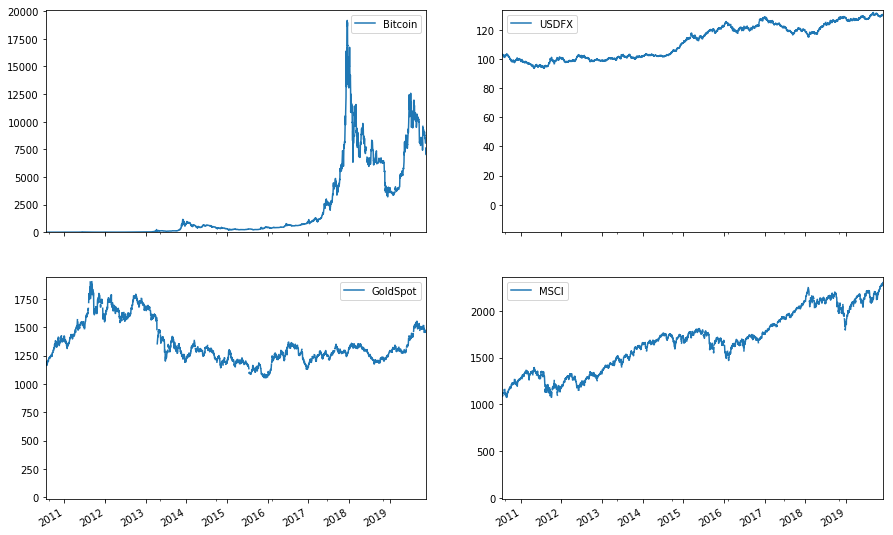

In [51]:
# Plot prices 2010-2019

plt.rcParams['figure.figsize'] = [15, 10] #set figure width, height
Plot17 = pd.concat([BTC19, USD19, GoldSpot19, MSCI19], axis = 1)
Plot17.plot(subplots=True, layout=(2,2), color='tab:blue', ylim=(-19))
plt.show()

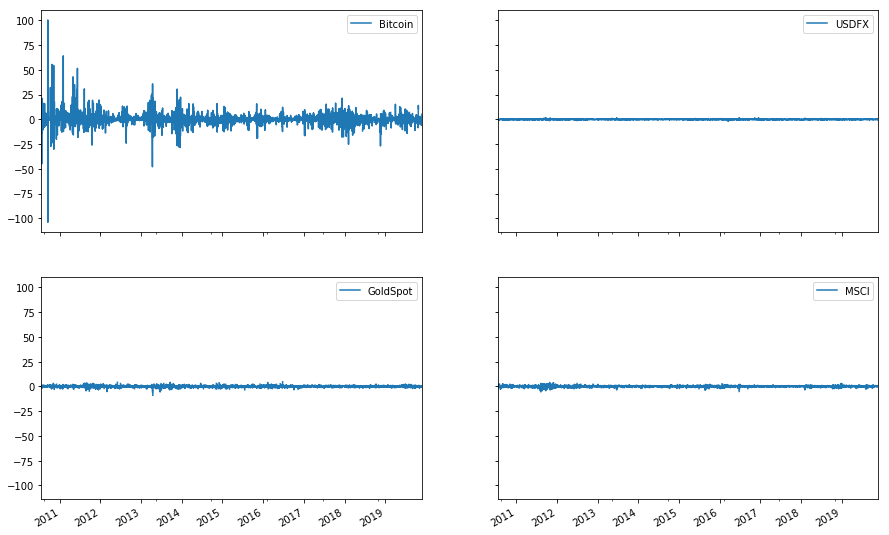

In [52]:
# Plot returns 2010-2019

plt.rcParams['figure.figsize'] = [15, 10] #set figure width, height
Plot17_r = pd.concat([BTC19_r, USD19_r, GoldSpot19_r, MSCI19_r], axis = 1)
Plot17_r.plot(subplots=True, layout=(2,2), color='tab:blue', sharey=True)
plt.show()

In [53]:
# AR(1)-Process - Data 2010-2019

ar1 = pd.DataFrame(np.zeros(len(Data19.columns)), columns=['AR(1)'], index=Data19_stats.index)
pval = pd.DataFrame(np.zeros(len(Data19.columns)), columns=['AR(1)'], index=Data19_stats.index)

for i in range(len(Data19.columns)):
    AR_Input = Data19.iloc[:,i].dropna()

    # fit the AR(1) model
    order = (1,0)
    ar_1 = ARMA(AR_Input, order=order)
    ar_1_fit = ar_1.fit()

    ar1.iloc[i] = ar_1_fit.params[1].round(4)
    pval.iloc[i] = ar_1_fit.pvalues[1]

# create three masks
s1 = ar1.applymap(lambda x: '{}*'.format(x))
s2 = ar1.applymap(lambda x: '{}**'.format(x))
s3 = ar1.applymap(lambda x: '{}***'.format(x))
# apply them where appropriate
for j in range(len(ar1)):
    ar1 = ar1.mask(pval<=0.1,s1)
    ar1 = ar1.mask(pval<=0.05,s2)
    ar1 = ar1.mask(pval<=0.01,s3)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/usr/local/lib/python3.6/dist-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind

In [54]:
# Augmented Dickey-Fuller test - Data 2010-2019

adf = pd.DataFrame(np.zeros(len(Data19.columns)), columns=['ADF'], index=Data19_stats.index)
pval = pd.DataFrame(np.zeros(len(Data19.columns)), columns=['ADF'], index=Data19_stats.index)
for j in range(len(Data19.columns)):
    adf.iloc[j] = adfuller(Data19.iloc[:,j].dropna())[0].round(2)
    pval.iloc[j] = adfuller(Data19.iloc[:,j].dropna())[1]
# create three masks
s1 = adf.applymap(lambda x: '{}*'.format(x))
s2 = adf.applymap(lambda x: '{}**'.format(x))
s3 = adf.applymap(lambda x: '{}***'.format(x))
# apply them where appropriate
for i in range(len(adf)):
    adf = adf.mask(pval<=0.1,s1)
    adf = adf.mask(pval<=0.05,s2)
    adf = adf.mask(pval<=0.01,s3)

In [55]:
# Complete summary statistics 2010-2019
Data19_stats['AR(1)'] = ar1
Data19_stats['ADF'] = adf
Data19_stats

,count,mean,std,min,50%,max,skew,kurt,AR(1),ADF
Bitcoin,3365.0,0.340017,6.283626,-103.926579,0.058894,100.434161,0.688842,55.305325,-0.0709***,-11.79***
FedFund,2353.0,0.000892,0.098551,-0.773190,0.000000,0.902868,0.740053,22.605284,-0.4021***,-10.44***
USDEUR,2442.0,-0.006657,0.543501,-2.652879,0.000000,3.029480,-0.031261,1.948784,-0.0195,-50.36***
USDGBP,2442.0,-0.006715,0.542548,-8.401591,-0.006179,2.984442,-1.471123,24.703614,-0.01,-49.88***
USDFX,2329.0,0.010047,0.296384,-1.992206,0.004701,1.734023,0.194513,3.280311,0.0421**,-16.28***
EURFX,2946.0,-0.000050,0.390673,-2.158786,0.010420,2.306641,-0.083539,3.543490,-0.019,-28.72***
FTSE100,2367.0,0.015498,0.911883,-4.779456,0.037385,3.942950,-0.227143,2.466166,0.0238,-26.74***
MSCI,2441.0,0.030665,0.796139,-5.256135,0.055410,4.111951,-0.576195,4.765263,0.1289***,-24.17***
GoldFuture,2362.0,0.008762,0.994825,-9.820577,0.013378,4.602635,-0.736870,7.471775,-0.0416**,-50.63***
GoldSpot,2437.0,0.008510,0.948161,-8.875565,0.022457,4.692827,-0.587199,6.178626,-0.0092,-49.79***


In [56]:
# Correlation Matrix of Data19

Corr_Data19 = Data19[['Bitcoin','USDEUR','USDGBP','USDFX','EURFX','FTSE100','MSCI','GoldSpot','GoldFuture']]

# Calculate the correlation matrix and assemble with p-values
rho = Corr_Data19.corr()
rho = rho.round(3)
pval = calculate_pvalues(Corr_Data19)
# create three masks
r1 = rho.applymap(lambda x: '{}*'.format(x))
r2 = rho.applymap(lambda x: '{}**'.format(x))
r3 = rho.applymap(lambda x: '{}***'.format(x))
# apply them where appropriate
rho = rho.mask(pval<=0.1,r1)
rho = rho.mask(pval<=0.05,r2)
rho = rho.mask(pval<=0.01,r3)
rho

,Bitcoin,USDEUR,USDGBP,USDFX,EURFX,FTSE100,MSCI,GoldSpot,GoldFuture
Bitcoin,1.0***,0.04**,0.027,-0.019,0.041**,0.032,0.043**,0.023,0.026
USDEUR,0.04**,1.0***,0.565***,-0.601***,0.892***,0.084***,0.303***,0.31***,0.263***
USDGBP,0.027,0.565***,1.0***,-0.485***,0.379***,0.037*,0.329***,0.211***,0.177***
USDFX,-0.019,-0.601***,-0.485***,1.0***,-0.464***,-0.335***,-0.516***,-0.327***,-0.408***
EURFX,0.041**,0.892***,0.379***,-0.464***,1.0***,0.1***,0.269***,0.199***,0.169***
FTSE100,0.032,0.084***,0.037*,-0.335***,0.1***,1.0***,0.761***,-0.033,-0.001
MSCI,0.043**,0.303***,0.329***,-0.516***,0.269***,0.761***,1.0***,0.033*,0.063***
GoldSpot,0.023,0.31***,0.211***,-0.327***,0.199***,-0.033,0.033*,1.0***,0.889***
GoldFuture,0.026,0.263***,0.177***,-0.408***,0.169***,-0.001,0.063***,0.889***,1.0***


In [57]:
# Data preparation for GARCH analysis 2010-2019

Garch_Data19 = Data19[['Bitcoin','USDEUR','USDGBP','FTSE100','MSCI','GoldFuture','GoldSpot']]

In [58]:
# GJR-GARCH(1,1) 2010-2019

# Data preparation for GJR-GARCH analysis 2010-2019
Garch_Data19 = Data19[['Bitcoin','USDEUR','USDGBP','FTSE100','MSCI','GoldFuture','GoldSpot']]

# Define function for adding significance levels
def significance(a,p):
    # create three masks
    s1 = a.applymap(lambda x: '{}*'.format(x))
    s2 = a.applymap(lambda x: '{}**'.format(x))
    s3 = a.applymap(lambda x: '{}***'.format(x))
    # apply them where appropriate
    for j in range(len(a)):
        a = a.mask(p<=0.1,s1)
        a = a.mask(p<=0.05,s2)
        a = a.mask(p<=0.01,s3)
    return a

# Prepare Datasets for GJR-GARCH coefficients and p-values
Garch_Data = Garch_Data19

const = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['Constant (Mean)'], index=Garch_Data.transpose().index)
ar_1 = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['AR(1)'], index=Garch_Data.transpose().index)
alpha = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['α'], index=Garch_Data.transpose().index)
gamma = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['γ'], index=Garch_Data.transpose().index)
beta = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['β'], index=Garch_Data.transpose().index)
omega = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['Constant (Variance)'], index=Garch_Data.transpose().index)
obs = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['Observations'], index=Garch_Data.transpose().index)

p1 = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['Constant (Mean)'], index=Garch_Data.transpose().index)
p2 = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['AR(1)'], index=Garch_Data.transpose().index)
p3 = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['α'], index=Garch_Data.transpose().index)
p4 = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['γ'], index=Garch_Data.transpose().index)
p5 = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['β'], index=Garch_Data.transpose().index)
p6 = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['Constant (Variance)'], index=Garch_Data.transpose().index)

# Calculate and assemble coefficients and p-values
for i in range(len(Garch_Data.columns)):
    GJR_Input = Garch_Data.iloc[:,i].dropna()

    # fit the AR(1) model
    am = ARX(GJR_Input, lags=1)
    am.volatility = GARCH(1, 1, 1)
    am.distribution = Normal()
    res = am.fit()
    
    const.iloc[i] = res.params[0].round(6)
    ar_1.iloc[i] = res.params[1].round(6)
    alpha.iloc[i] = res.params[3].round(6)
    gamma.iloc[i] = res.params[4].round(6)
    beta.iloc[i] = res.params[5].round(6)
    omega.iloc[i] = res.params[2].round(6)
    obs.iloc[i] = res.nobs
    
    p1.iloc[i] = res.pvalues[0]
    p2.iloc[i] = res.pvalues[1]
    p3.iloc[i] = res.pvalues[3]
    p4.iloc[i] = res.pvalues[4]
    p5.iloc[i] = res.pvalues[5]
    p6.iloc[i] = res.pvalues[2]

const = significance(const,p1)
ar_1 = significance(ar_1,p2)
alpha = significance(alpha,p3)
gamma = significance(gamma,p4)
beta = significance(beta,p5)
omega = significance(omega,p6)

# Concatenate variables' results
GJR_19 = pd.concat([const, ar_1, alpha, gamma, beta, omega, obs], axis=1)
GJR_19 = GJR_19.transpose()
GJR_19

Iteration:      1,   Func. Count:      8,   Neg. LLF: 9915.679852380412
Iteration:      2,   Func. Count:     19,   Neg. LLF: 9912.75300126693
Iteration:      3,   Func. Count:     30,   Neg. LLF: 9908.679089776522
Iteration:      4,   Func. Count:     40,   Neg. LLF: 9905.942211850881
Iteration:      5,   Func. Count:     49,   Neg. LLF: 9857.319458837783
Iteration:      6,   Func. Count:     58,   Neg. LLF: 9801.88891980805
Iteration:      7,   Func. Count:     67,   Neg. LLF: 9787.740289160782
Iteration:      8,   Func. Count:     76,   Neg. LLF: 9784.610729901851
Iteration:      9,   Func. Count:     87,   Neg. LLF: 9784.344100274113
Iteration:     10,   Func. Count:     95,   Neg. LLF: 9774.884554399841
Iteration:     11,   Func. Count:    103,   Neg. LLF: 9774.672510647582
Iteration:     12,   Func. Count:    111,   Neg. LLF: 9774.39801532519
Iteration:     13,   Func. Count:    119,   Neg. LLF: 9774.399175673225
Iteration:     14,   Func. Count:    127,   Neg. LLF: 9774.39747085

,Bitcoin,USDEUR,USDGBP,FTSE100,MSCI,GoldFuture,GoldSpot
Constant (Mean),0.16787***,-0.004992,-0.002275,0.059632***,0.070138***,0.013703,0.008842
AR(1),-0.033981,-0.019697,-0.007696,0.009715,0.096812***,-0.043078**,-0.021623
α,0.105898***,0.039914***,0.069529***,0.155133***,0.181596***,0.042287***,0.050189***
γ,-0.024058,-0.020815*,0.01682,-0.155133***,-0.181596***,-0.019961,-0.016782
β,0.906132***,0.968306***,0.894295***,0.917579***,0.909204***,0.960721***,0.948357***
Constant (Variance),0.155481,0.000974**,0.008533,0.010848,0.005658,0.007715,0.009584
Observations,3364,2441,2441,2366,2440,2361,2436


In [59]:
# GJR-GARCH(1,1)-X 2010-2019

# Data preparation for GJR-GARCH-X analysis 2010-2019
Garch_Data19_X = Data19[['Bitcoin','USDEUR','USDGBP','FTSE100','MSCI','GoldFuture','GoldSpot','USDFX']]

# Define function for adding significance levels
def significance(a,p):
    # create three masks
    s1 = a.applymap(lambda x: '{}*'.format(x))
    s2 = a.applymap(lambda x: '{}**'.format(x))
    s3 = a.applymap(lambda x: '{}***'.format(x))
    # apply them where appropriate
    for j in range(len(a)):
        a = a.mask(p<=0.1,s1)
        a = a.mask(p<=0.05,s2)
        a = a.mask(p<=0.01,s3)
    return a

# Prepare Datasets for GJR-GARCH coefficients and p-values
Garch_Data = Garch_Data19_X.dropna().iloc[:,:7]
x = pd.DataFrame(Garch_Data19_X.dropna().iloc[:,-1])

# Calculate and assemble coefficients and p-values
const = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['Constant (Mean)'], index=Garch_Data.transpose().index)
ar_1 = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['AR(1)'], index=Garch_Data.transpose().index)
alpha = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['α'], index=Garch_Data.transpose().index)
gamma = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['γ'], index=Garch_Data.transpose().index)
beta = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['β'], index=Garch_Data.transpose().index)
omega = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['Constant (Variance)'], index=Garch_Data.transpose().index)
obs = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['Observations'], index=Garch_Data.transpose().index)
usdfx = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['USD FX index return'], index=Garch_Data.transpose().index)

p1 = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['Constant (Mean)'], index=Garch_Data.transpose().index)
p2 = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['AR(1)'], index=Garch_Data.transpose().index)
p3 = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['α'], index=Garch_Data.transpose().index)
p4 = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['γ'], index=Garch_Data.transpose().index)
p5 = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['β'], index=Garch_Data.transpose().index)
p6 = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['Constant (Variance)'], index=Garch_Data.transpose().index)
p7 = pd.DataFrame(np.zeros(len(Garch_Data.columns)), columns=['USD FX index return'], index=Garch_Data.transpose().index)

for i in range(len(Garch_Data.columns)):
    GJR_Input = Garch_Data.iloc[:,i]
    
    # fit the AR(1) model
    am = ARX(GJR_Input, x, lags=1)
    am.volatility = GARCH(1, 1, 1)
    am.distribution = Normal()
    res = am.fit()
    
    const.iloc[i] = res.params[0].round(6)
    ar_1.iloc[i] = res.params[1].round(6)
    alpha.iloc[i] = res.params[4].round(6)
    gamma.iloc[i] = res.params[5].round(6)
    beta.iloc[i] = res.params[6].round(6)
    omega.iloc[i] = res.params[3].round(6)
    usdfx.iloc[i] = res.params[2].round(6)
    obs.iloc[i] = res.nobs
    
    p1.iloc[i] = res.pvalues[0]
    p2.iloc[i] = res.pvalues[1]
    p3.iloc[i] = res.pvalues[4]
    p4.iloc[i] = res.pvalues[5]
    p5.iloc[i] = res.pvalues[6]
    p6.iloc[i] = res.pvalues[3]
    p7.iloc[i] = res.pvalues[2]
    
const = significance(const,p1)
ar_1 = significance(ar_1,p2)
alpha = significance(alpha,p3)
gamma = significance(gamma,p4)
beta = significance(beta,p5)
omega = significance(omega,p6)
usdfx = significance(usdfx,p7)

# Concatenate variables' results
GJR_X_19 = pd.concat([const, ar_1, usdfx, alpha, gamma, beta, omega, obs], axis=1)
GJR_X_19 = GJR_X_19.transpose()
GJR_X_19

Iteration:      1,   Func. Count:      9,   Neg. LLF: 6781.722541004896
Iteration:      2,   Func. Count:     22,   Neg. LLF: 6772.715069066499
Iteration:      3,   Func. Count:     33,   Neg. LLF: 6771.31065519716
Iteration:      4,   Func. Count:     43,   Neg. LLF: 6763.7487800418285
Iteration:      5,   Func. Count:     54,   Neg. LLF: 6763.307719283821
Iteration:      6,   Func. Count:     64,   Neg. LLF: 6755.159484211755
Iteration:      7,   Func. Count:     74,   Neg. LLF: 6749.605653725836
Iteration:      8,   Func. Count:     84,   Neg. LLF: 6725.767247238546
Iteration:      9,   Func. Count:     96,   Neg. LLF: 6725.526482183874
Iteration:     10,   Func. Count:    105,   Neg. LLF: 6716.985242429402
Iteration:     11,   Func. Count:    114,   Neg. LLF: 6710.050825399148
Iteration:     12,   Func. Count:    123,   Neg. LLF: 6708.537706014313
Iteration:     13,   Func. Count:    132,   Neg. LLF: 6708.162574647717
Iteration:     14,   Func. Count:    141,   Neg. LLF: 6708.01986

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:     14,   Func. Count:    147,   Neg. LLF: 2658.246003380539
Iteration:     15,   Func. Count:    157,   Neg. LLF: 2657.660142751958
Iteration:     16,   Func. Count:    169,   Neg. LLF: 2657.639864367112
Iteration:     17,   Func. Count:    180,   Neg. LLF: 2657.4539536677494
Iteration:     18,   Func. Count:    189,   Neg. LLF: 2657.284260356548
Iteration:     19,   Func. Count:    198,   Neg. LLF: 2657.2526625293035
Iteration:     20,   Func. Count:    207,   Neg. LLF: 2657.2515148774755
Iteration:     21,   Func. Count:    216,   Neg. LLF: 2657.2514995723996
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2657.2514995720267
            Iterations: 21
            Function evaluations: 216
            Gradient evaluations: 21
Iteration:      1,   Func. Count:      9,   Neg. LLF: 2153.0498559388243
Iteration:      2,   Func. Count:     22,   Neg. LLF: 2149.2201773292672
Iteration:      3,   Func. Count:     35,   Neg. LLF: 2141.349

,Bitcoin,USDEUR,USDGBP,FTSE100,MSCI,GoldFuture,GoldSpot
Constant (Mean),0.196559**,-0.001756,0.001457,0.062459***,0.082373***,0.008364,0.007564
AR(1),0.024009,-0.003985,-0.000347,-0.001402,0.083716***,-0.008993,0.002153
USD FX index return,-0.048767,-1.065211***,-0.834601***,-0.752812***,-1.060118***,-1.432691***,-1.152493***
α,0.08516***,0.032368***,0.077992,0.148165***,0.209655***,0.09346**,0.125787**
γ,0.027597,0.013394,0.03663,-0.145337***,-0.209655***,-0.024076,-0.071657
β,0.901042***,0.955669***,0.848428***,0.904045***,0.895173***,0.905006***,0.890929***
Constant (Variance),0.230518,0.001281**,0.012973,0.018855**,0.008133,0.014952*,0.019546**
Observations,2246,2246,2246,2246,2246,2246,2246
